## Preliminary Steps

In [2]:
! pip install transformers datasets pytorch_metric_learning faiss-gpu umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! wget https://raw.githubusercontent.com/drchapman-17/LyricStyleSpace/main/data/data.json
! wget https://raw.githubusercontent.com/drchapman-17/LyricStyleSpace/main/data/data_self_dump.json

--2023-05-15 15:00:42--  https://raw.githubusercontent.com/drchapman-17/LyricStyleSpace/main/data/data.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21129622 (20M) [text/plain]
Saving to: ‘data.json.1’

data.json.1         100%[===================>]  20.15M  --.-KB/s    in 0.1s    

2023-05-15 15:00:43 (154 MB/s) - ‘data.json.1’ saved [21129622/21129622]

--2023-05-15 15:00:43--  https://raw.githubusercontent.com/drchapman-17/LyricStyleSpace/main/data/data_self_dump.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22737

In [4]:
import numpy as np
import torch
import random
import os 
import matplotlib.pyplot as plt
import gc
import os 
import umap
import re

from tqdm.notebook import tqdm

from torch import nn
from torch import Tensor
from torch.nn.utils.clip_grad import clip_grad_norm_
from torch.utils.data import DataLoader
from torch.utils.data import Dataset,DataLoader
from torch.utils.tensorboard import SummaryWriter

from datasets import DatasetDict
from datasets import load_dataset
from transformers import AutoModel, AutoTokenizer

from typing import Optional,Union,Tuple, Dict, Any, Iterator, Sequence

In [5]:
def set_reproducibility(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.use_deterministic_algorithms(True)
  g_torch.manual_seed(random_seed)
  g_np = np.random.default_rng (seed=random_seed)
  os.environ['CUBLAS_WORKSPACE_CONFIG']=':16:8'

def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

random_seed = 42
g_torch = torch.Generator()
g_np = np.random.default_rng (seed=random_seed)
set_reproducibility(random_seed)

# Dataset Processing

## Load Dataset

In [6]:
# dataset = load_dataset('json',data_files='data.json').class_encode_column('artist')
dataset = load_dataset('json',data_files='data_self_dump.json').class_encode_column('artist').filter(lambda x: len(x['lyrics'])>0)
artists_mappings = dataset['train'].features['artist'].names

  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
def clean(example):
    # allowed_parts = ['verse','break','chorus','intro', 'interlude', 'bridge', 'outro']
    allowed_parts = None
    example['lyrics']=example['lyrics'][example['lyrics'].index('Lyrics')+6:] 
    if allowed_parts is not None: 
        for part in allowed_parts:
            example['lyrics']=re.sub("\[.*"+part+".*\]", f"[{part}]", example['lyrics'], flags=re.IGNORECASE)
        example['lyrics']=re.sub("\[(?!"+"|".join(allowed_parts)+").*?\]", "", example['lyrics'], flags=re.DOTALL)
    else: 
        example['lyrics']=re.sub("\[.*\]", "", example['lyrics'], flags=re.IGNORECASE)
    example['lyrics']=re.sub("[0-9]+embed", "", example['lyrics'], flags=re.IGNORECASE)
    return example

mapped_dataset = dataset.map(clean)

## Train/Test/Val Split

In [8]:
tts_mapped_dataset = mapped_dataset['train'].train_test_split(train_size=0.7,stratify_by_column='artist')
tvs_mapped_dataset = tts_mapped_dataset['test'].train_test_split(train_size=0.5,stratify_by_column='artist')

train_test_val_dataset = DatasetDict({
    'train': tts_mapped_dataset['train'],
    'test':tvs_mapped_dataset['test'],
    'val': tvs_mapped_dataset['train']
    
})

In [9]:
def plot_dist(dataset,**kwargs):
    counts = {}
    for example in dataset:
        if example['artist'] not in counts.keys():
            counts[example['artist']] = 0
        else:
            counts[example['artist']] += 1
    plt.bar(counts.keys(), counts.values(),**kwargs)

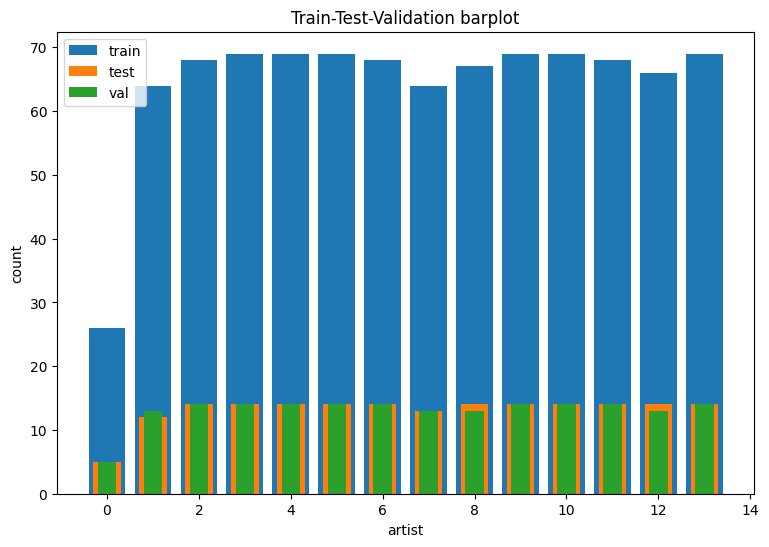

In [10]:
plt.figure(figsize=(9,6))
plt.title("Train-Test-Validation barplot")
plt.ylabel("count")
plt.xlabel("artist")
plot_dist(train_test_val_dataset['train'],width=0.8)
plot_dist(train_test_val_dataset['test'],width=0.6)
plot_dist(train_test_val_dataset['val'],width=0.4)
plt.legend(['train', 'test', 'val'])
plt.show()

# Machine Learning

## Euclidean Distance


In [11]:
class EuclideanDistance(nn.Module):
    """Implement a EuclideanDistance object."""

    def forward(self, mat_1: Tensor, mat_2: Tensor) -> Tensor:  # type: ignore
        """Returns the squared euclidean distance between each
        element in mat_1 and each element in mat_2.

        Parameters
        ----------
        mat_1: torch.Tensor
            matrix of shape (n_1, n_features)
        mat_2: torch.Tensor
            matrix of shape (n_2, n_features)

        Returns
        -------
        dist: torch.Tensor
            distance matrix of shape (n_1, n_2)

        """
        _dist = [torch.sum((mat_1 - mat_2[i])**2, dim=1) for i in range(mat_2.size(0))]
        dist = torch.stack(_dist, dim=1)
        return dist


class EuclideanMean(nn.Module):
    """Implement a EuclideanMean object."""

    def forward(self, data: Tensor) -> Tensor:  # type: ignore
        """Performs a forward pass through the network.

        Parameters
        ----------
        data : torch.Tensor
            The input data, as a float tensor

        Returns
        -------
        torch.Tensor
            The encoded output, as a float tensor

        """
        return data.mean(0)


## Hyperbolic distance

In [12]:
EPSILON = 1e-5


def arccosh(x):
    """Compute the arcosh, numerically stable."""
    x = torch.clamp(x, min=1 + EPSILON)
    a = torch.log(x)
    b = torch.log1p(torch.sqrt(x * x - 1) / x)
    return a + b


def mdot(x, y):
    """Compute the inner product."""
    m = x.new_ones(1, x.size(1))
    m[0, 0] = -1
    return torch.sum(m * x * y, 1, keepdim=True)


def dist(x, y):
    """Get the hyperbolic distance between x and y."""
    return arccosh(-mdot(x, y))


def project(x):
    """Project onto the hyeprboloid embedded in in n+1 dimensions."""
    return torch.cat([torch.sqrt(1.0 + torch.sum(x * x, 1, keepdim=True)), x], 1)


def log_map(x, y):
    """Perform the log step."""
    d = dist(x, y)
    return (d / torch.sinh(d)) * (y - torch.cosh(d) * x)


def norm(x):
    """Compute the norm"""
    n = torch.sqrt(torch.abs(mdot(x, x)))
    return n


def exp_map(x, y):
    """Perform the exp step."""
    n = torch.clamp(norm(y), min=EPSILON)
    return torch.cosh(n) * x + (torch.sinh(n) / n) * y


def loss(x, y):
    """Get the loss for the optimizer."""
    return torch.sum(dist(x, y)**2)


class HyperbolicDistance(nn.Module):
    """Implement a HyperbolicDistance object.

    """

    def forward(self, mat_1: Tensor, mat_2: Tensor) -> Tensor:  # type: ignore
        """Returns the squared euclidean distance between each
        element in mat_1 and each element in mat_2.

        Parameters
        ----------
        mat_1: torch.Tensor
            matrix of shape (n_1, n_features)
        mat_2: torch.Tensor
            matrix of shape (n_2, n_features)

        Returns
        -------
        dist: torch.Tensor
            distance matrix of shape (n_1, n_2)

        """
        # Get projected 1st dimension
        mat_1_x_0 = torch.sqrt(1 + mat_1.pow(2).sum(dim=1, keepdim=True))
        mat_2_x_0 = torch.sqrt(1 + mat_2.pow(2).sum(dim=1, keepdim=True))

        # Compute bilinear form
        left = mat_1_x_0.mm(mat_2_x_0.t())  # n_1 x n_2
        right = mat_1[:, 1:].mm(mat_2[:, 1:].t())  # n_1 x n_2

        # Arcosh
        return arccosh(left - right).pow(2)


class HyperbolicMean(nn.Module):
    """Compute the mean point in the hyperboloid model."""

    def forward(self, data: Tensor) -> Tensor:  # type: ignore
        """Performs a forward pass through the network.

        Parameters
        ----------
        data : torch.Tensor
            The input data, as a float tensor

        Returns
        -------
        torch.Tensor
            The encoded output, as a float tensor

        """
        n_iter = 5 if self.training else 100

        # Project the input data to n+1 dimensions
        projected = project(data)

        mean = torch.mean(projected, 0, keepdim=True)
        mean = mean / norm(mean)

        r = 1e-2
        for i in range(n_iter):
            g = -2 * torch.mean(log_map(mean, projected), 0, keepdim=True)
            mean = exp_map(mean, -r * g)
            mean = mean / norm(mean)

        # The first dimension, is recomputed in the distance module
        return mean.squeeze()[1:]


## Model definition and tokenization

In [13]:
class PrototypicalTransformerModel(torch.nn.Module):
    
    def __init__(self,
                 model_ckpt: str,
                 output_dim: int,
                ) -> None:
        super().__init__()
        self.transformer = AutoModel.from_pretrained(model_ckpt)
        self.dense_layer = torch.nn.Linear(self.transformer.config.hidden_size, output_dim)
      
    def forward(self,  # type: ignore
                input_ids: Tensor,
                attention_mask: Tensor,
                ) -> Union[Tensor, Tuple[Tensor, Tensor]]:

        query_embedding = self.transformer(input_ids = input_ids, attention_mask = attention_mask)
        # return torch.nn.functional.relu(self.dense_layer(query_embedding["pooler_output"]))
        return self.dense_layer(query_embedding["pooler_output"])

In [14]:
device = 'cpu'
if torch.cuda.is_available():
  device='cuda'
  print('All good. A CPU is availbale')
else: 
  print('Restart the runtime with a compatible CUDA device.')

# Create model with warm-start weights from pretrained checkpoint
# model_ckpt = 'bert-base-uncased'
model_ckpt = 'distilroberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = PrototypicalTransformerModel(model_ckpt,128).to(device)


All good. A CPU is availbale


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
# Tokenize
def prepare_train_features(examples):
    tokenized_examples = tokenizer(
        examples['lyrics'],
        truncation=True,
        padding=True,
        max_length=512
        )
    tokenized_examples['labels'] = examples['artist']
    return tokenized_examples

train_features = train_test_val_dataset['train'].map(prepare_train_features, batched=True, remove_columns=train_test_val_dataset["train"].column_names).with_format('torch')
test_features = train_test_val_dataset['test'].map(prepare_train_features, batched=True, remove_columns=train_test_val_dataset["test"].column_names).with_format('torch')
val_features = train_test_val_dataset['val'].map(prepare_train_features, batched=True, remove_columns=train_test_val_dataset["val"].column_names).with_format('torch')

Map:   0%|          | 0/197 [00:00<?, ? examples/s]

## Utilities

In [16]:
class MyDataset(Dataset):
    def __init__(self,dataset) -> None:
        super().__init__()
        self.dataset = dataset
    def __getitem__(self, index):
        index = int(index)
        return (self.dataset[index]['input_ids'],self.dataset[index]['attention_mask']),self.dataset[index]['labels']
    def __len__(self):
        return len(self.dataset)

In [17]:
def get_all_embeddings(dataset, model,device):
  dataloader = DataLoader(dataset,batch_size=16)
  embeddings = []
  labels = []
  model.eval()
  with torch.no_grad():
    for _,((input_ids,attention_mask),label), in enumerate(tqdm(dataloader)):
      labels.append(label)
      input_ids = input_ids.to(device)
      attention_mask = attention_mask.to(device)
      embeddings.append(model(input_ids,attention_mask))
  return torch.vstack(embeddings), torch.cat(labels)

In [64]:
from cycler import cycler

def visualize_embeddings(embeddings, labels,label_mappings):
  label_set = np.unique(labels)
  num_classes = len(label_set)
  fig = plt.figure(figsize=(10,10))
  plt.gca().set_prop_cycle(
      cycler(
          "color", [plt.cm.nipy_spectral(i) for i in np.linspace(0,0.9, num_classes+3)]
      )
  )

  for i in range(num_classes):
    idx = (labels==label_set[i])
    plt.plot(embeddings[idx,0], embeddings[idx,1], ".", markersize=10, label=label_mappings[label_set[i]])
  plt.legend(loc="best", markerscale=1)
  return fig 

In [19]:
def clear_cache():
  gc.collect()
  torch.cuda.empty_cache()
  torch.cuda.synchronize()
   
clear_cache()
print(f'{torch.cuda.memory_allocated()/1024**2} MB')
! nvidia-smi

314.87451171875 MB
Mon May 15 15:00:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    26W /  70W |   1217MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                     

## Samplers

In [20]:
class EpisodicSampler(object):
    """Implement an Episodic sampler."""

    def __init__(self,
                 data: Sequence[Tuple[Tuple[Tensor,Tensor], Tensor]],
                 n_support: int,
                 n_query: int,
                 n_episodes: int,
                 n_classes: int = None,
                 balance_query: bool = False) -> None:
        """Initialize the EpisodicSampler.

        Parameters
        ----------
        data: Sequence[Tuple[torch.Tensor, torch.Tensor]]
            The input data as a list of (sequence, label) pairs
        n_support : int
            The number of support points per class
        n_query : int
            If balance_query is True, this should be the number
            of query points per class, otherwise, this is the total
            number of query points for the episode
        n_episodes : int
            Number of episodes to run in one "epoch"
        n_classes : int, optional
            The number of classes to sample per episode, defaults to all
        pad_index : int, optional
            The padding index used on sequences.
        balance_query : bool, optional
            If True, the same number of query points are sampled per
            class, otherwise query points are sampled uniformly
            from the input data.

        """

        self.n_support = n_support
        self.n_query = n_query
        self.n_classes = n_classes
        self.n_episodes = n_episodes

        self.balance_query = balance_query

        if len(data) == 0:
            raise ValueError("No examples provided")

        # Split dataset by target
        self.target_to_examples: Dict[int, Any] = dict()
        for source, target in data:
            self.target_to_examples.setdefault(int(target), []).append((source, target))

        self.all_classes = list(self.target_to_examples.keys())

    def __iter__(self) -> Iterator[Tuple[torch.Tensor, ...]]:
        """Sample from the list of features and yields batches.

        Yields
        ------
        Iterator[Tuple[Tensor, Tensor, Tensor, Tensor]]
            In order: the query_source, the query_target
            the support_source, and the support_target tensors.
            For sequences, the batch is used as first dimension.

        """
        for _ in range(self.n_episodes):
            # Sample n_classes to run a training episode over
            classes = self.all_classes
            if self.n_classes is not None:
                classes = list(np.random.permutation(self.all_classes))[:self.n_classes]
            # Sample n_support and n_query points per class
            supports, queries = [], []
            for i, target_class in enumerate(classes):
                examples = self.target_to_examples[target_class]
                indices = np.random.permutation(len(examples))
                supports.extend([(examples[j][0], i) for j in indices[:self.n_support]])

                if self.balance_query:
                    query_indices = indices[self.n_support:self.n_support + self.n_query]
                    queries.extend([(examples[j][0], i) for j in query_indices])
                else:
                    queries.extend([(examples[j][0], i) for j in indices[self.n_support:]])

            if not self.balance_query:
                indices = np.random.permutation(len(queries))
                queries = [queries[i] for i in indices[:self.n_query]]

            query_source, query_target = list(zip(*queries))
            support_source, support_target = list(zip(*supports))

            query_input_ids,query_attention_mask = list(zip(*query_source))
            query_input_ids = torch.stack(query_input_ids)
            query_attention_mask = torch.stack(query_attention_mask)

            query_target = torch.tensor(query_target)

            support_input_ids,support_attention_mask = list(zip(*support_source))
            support_input_ids = torch.stack(support_input_ids)
            support_attention_mask = torch.stack(support_attention_mask)

            support_target = torch.tensor(support_target)

            if len(query_target.size()) == 2:
                query_target = query_target.squeeze()
            if len(support_target.size()) == 2:
                support_target = support_target.squeeze()

            yield (query_input_ids.long(),
                   query_attention_mask.long(),
                   query_target.long(),
                   support_input_ids.long(),
                   support_attention_mask.long(),
                   support_target.long())
            
    def __len__(self):
      return self.n_episodes

class BaseSampler(object):

    def __init__(self,
                 data: Sequence,
                 shuffle: bool = True,
                 batch_size: int = 16):
        """A basic sampler.

        Parameters
        ----------
        data : Sequence[Tuple[Tensor, Tensor]]
            The input data to sample from, as a list of
            (source, target) pairs
        shuffle : bool, optional
            Whether to shuffle the data, by default True
        batch_size : int, optional
            The batch size to use, by default 16

        """
        self.data = data
        self.shuffle = shuffle
        self.batch_size = batch_size

    def __iter__(self):
        """Sample from the list of features and yields batches.

        Yields
        ------
        Iterator[Tuple[Tensor, Tensor]]
            In order: source, target
            For sequences, the batch is used as first dimension.

        """
        if self.shuffle:
            indices = np.random.permutation(len(self.data))
        else:
            indices = list(range(len(self.data)))

        num_batches = len(indices) // self.batch_size
        indices_splits = np.array_split(indices, num_batches)
        for split in indices_splits:
            examples = [self.data[i] for i in split]
            source, target = list(zip(*examples))
            source_input_ids,source_attention_mask = list(zip(*source))
            source_input_ids = torch.stack(source_input_ids)
            source_attention_mask = torch.stack(source_attention_mask)
            target = torch.tensor(target)
            yield (source_input_ids.long(),source_attention_mask.long(), target.long())



## Training Loop

### Definition

In [21]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
class Trainer:
    def __init__(self,
                model,
                train_sampler,
                train_eval_sampler,
                val_sampler,
                distance = 'euclidean',
                num_epochs=3,
                learning_rate = 1e-5,
                max_grad_norm=None,
                es_patience=0,
                es_min_delta=1e-4,
                output_dir = 'output',
                device='cpu'):
    
        self.model = model  
        self.train_sampler = train_sampler
        self.train_eval_sampler = train_eval_sampler
        self.val_sampler = val_sampler
        self.num_epochs = num_epochs
        self.optimizer = torch.optim.Adam((p for p in model.parameters() if p.requires_grad), lr=learning_rate)
        self.max_grad_norm = max_grad_norm
        self.output_dir = output_dir
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.device = device
        self.writer = SummaryWriter(log_dir=self.output_dir)

        if distance == 'euclidean': 
            self.distance_module = EuclideanDistance()
            self.mean_module = EuclideanMean()
        elif distance == 'hyperbolic': 
            self.distance_module = HyperbolicDistance()
            self.mean_module = HyperbolicMean()
        else: 
            raise ValueError(f"Distance should be one of: ['euclidean', 'hyperbolic'], but got {distance}")

        if es_patience > 0: 
            self.early_stopper = EarlyStopper(patience=es_patience, min_delta=es_min_delta)
        else:
            self.early_stopper = False
            
        self.global_step = 0

    def compute_prototypes(self,
                        support: Tensor, 
                        label: Tensor,) -> Tensor:
        """Set the current prototypes used for classification.

        Parameters
        ----------
        data : torch.Tensor
            Input encodings
        label : torch.Tensor
            Corresponding labels

        """
        means_dict: Dict[int, Any] = {}
        for i in range(support.size(0)):
            means_dict.setdefault(int(label[i]), []).append(support[i])

        means = []
        n_means = len(means_dict)

        for i in range(n_means):
            # Ensure that all contiguous indices are in the means dict
            supports = torch.stack(means_dict[i], dim=0)
            if supports.size(0) > 1:
                # mean = supports.mean(0).squeeze(0)
                mean = self.mean_module(supports).squeeze(0)
            else:
                mean = supports.squeeze(0)
            means.append(mean)

        prototypes = torch.stack(means, dim=0)
        return prototypes
 
    def training_step(self):
        num_batches = len(self.train_sampler)
        log_interval = 1
        self.model.train()
        avg_loss = 0
        avg_acc = 0
        with torch.enable_grad():
            for idx,batch in enumerate(tqdm(self.train_sampler,position=1)):
                # Zero the gradients and clear the accumulated loss

                self.optimizer.zero_grad()

                # Move to device
                batch = tuple(t.to(self.device) for t in batch)
                query_input_ids,query_attention_mask,query_label,support_input_ids,support_attention_mask,support_label = batch
                support_input_ids = torch.split(support_input_ids, self.train_sampler.n_support, dim=0)
                support_attention_mask = torch.split(support_attention_mask, self.train_sampler.n_support, dim=0)

                # Make a forward pass
                support_encodings = []
                for i in range(len(support_input_ids)):
                    support_encodings.append(self.model(support_input_ids[i],support_attention_mask[i]))
                prototypes =self.compute_prototypes(torch.cat(support_encodings,dim=0),support_label) 
                
                query_encoding = self.model(query_input_ids,query_attention_mask)
                
                # Compute loss
                dist = - self.distance_module(query_encoding, prototypes)

                loss = self.loss_fn(dist, query_label)
                loss.backward()
                avg_acc += (dist.argmax(dim=1) == query_label).float().mean().item()

                # Clip gradients if necessary
                if self.max_grad_norm is not None:
                    clip_grad_norm_(self.model.parameters(), self.max_grad_norm)

                # Optimize
                self.optimizer.step()

                # Log training loss
                train_loss = loss.item()
                if log_interval > 0:
                    if idx % log_interval == 0:
                        self.writer.add_scalar('Training/Loss_IT', train_loss, self.global_step)
                self.global_step += 1

                # Zero the gradients when exiting a train step
                self.optimizer.zero_grad()
                avg_loss += loss.item()
            return avg_loss/num_batches,avg_acc/num_batches



    def validation_step(self):
        self.model.eval()
        with torch.no_grad():

            # First compute prototypes over the training data
            embeddings, labels = [], []
            for batch in self.train_eval_sampler:
                source_input_ids,source_attention_mask, target = tuple(t.to(self.device) for t in batch)
                embedding = self.model(source_input_ids,source_attention_mask)
                labels.append(target.cpu())
                embeddings.append(embedding.cpu())
            # Compute prototypes
            embeddings = torch.cat(embeddings, dim=0)
            labels = torch.cat(labels, dim=0)
            prototypes = self.compute_prototypes(embeddings, labels).to(self.device)

            _preds, _targets = [], []
            for batch in self.val_sampler:
                # Move to device
                source_input_ids,source_attention_mask, target = tuple(t.to(self.device) for t in batch)
                query_encoding = self.model(source_input_ids,source_attention_mask)
                dist = - self.distance_module(query_encoding, prototypes)
                _preds.append(dist.cpu())
                _targets.append(target.cpu())

            preds = torch.cat(_preds, dim=0)
            targets = torch.cat(_targets, dim=0)
            val_loss = self.loss_fn(preds, targets).item()
            val_metric = (preds.argmax(dim=1) == targets).float().mean().item()
        return val_loss,val_metric

    def train(self):
        best_metric = None
        best_model: Dict[str, torch.Tensor] = dict()

        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

        for epoch in tqdm(range(self.num_epochs),position=0):
            #       TRAIN           #    
            train_loss,train_acc = self.training_step()

            #       EVALUATE        #
            val_loss,val_acc = self.validation_step()

            lr = self.optimizer.param_groups[0]['lr']
            # Update best model
            if best_metric is None or val_acc > best_metric:
                best_metric = val_acc
                best_model_state = self.model.state_dict()
                for k, t in best_model_state.items():
                    best_model_state[k] = t.cpu().detach()
                best_model = best_model_state

            # Log metrics
            tqdm.write(f'Epoch {epoch+1}/{self.num_epochs} - \
              train_loss={train_loss:0.3f}, train_acc={train_acc*100:0.2f}%, \
              val_loss={val_loss:0.3f}, val_acc={val_acc*100:0.2f}%')
            self.writer.add_scalar('Hyperparameters/Learning Rate', lr, epoch)
            self.writer.add_scalar('Training/Loss', train_loss, epoch)
            self.writer.add_scalar('Training/Accuracy', train_acc, epoch)
            self.writer.add_scalar('Validation/Loss', val_loss, epoch)
            self.writer.add_scalar('Validation/Accuracy', val_acc, epoch)

            # Early stopping condition
            if self.early_stopper and self.early_stopper.early_stop(validation_loss=val_loss): 
                tqdm.write('Early stopping')
                break
        # Save the best model
        print("Finished training.")
        torch.save(best_model, os.path.join(self.output_dir, 'model.pt'))

### Hyperparameters

In [22]:
output_dir = 'out/prototype'

# Training hyperparameters
learning_rate = 1e-5
es_patience = 5
es_min_delta = 1e-4
num_epochs = 50
max_grad_norm = 1

n_support = 8
n_query = 16
n_episodes = 20
n_classes = 3
eval_batch_size = 16

distance = 'euclidean'

# Create samplers
train_sampler = EpisodicSampler(MyDataset(train_features),
                                n_support=n_support,
                                n_query=n_query,
                                n_episodes=n_episodes,
                                n_classes=n_classes)

# The train_eval_sampler is used to computer prototypes over the full dataset
train_eval_sampler = BaseSampler(MyDataset(train_features), batch_size=eval_batch_size)
val_sampler = BaseSampler(MyDataset(train_features), batch_size=eval_batch_size)

### Train

In [24]:
clear_cache()
trainer = Trainer(model,
                  train_sampler,
                  train_eval_sampler ,
                  val_sampler,
                  distance = 'euclidean' ,
                  num_epochs=num_epochs,
                  learning_rate = learning_rate,
                  max_grad_norm= max_grad_norm ,
                  es_patience=es_patience,
                  es_min_delta=es_min_delta,
                  output_dir = output_dir+"/euclidean",
                  device=device)
set_reproducibility(random_seed)
trainer.train()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 1.0894440710544586
Validation loss: 2.4860520362854004
Validation accuracy: 0.5342763662338257


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.8813123226165771
Validation loss: 1.8607852458953857
Validation accuracy: 0.5244831442832947


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.566163158416748
Validation loss: 1.4918056726455688
Validation accuracy: 0.5397170782089233


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.5787264630198479
Validation loss: 1.3100876808166504
Validation accuracy: 0.5897715091705322


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.41757172234356404
Validation loss: 1.193459391593933
Validation accuracy: 0.6430903077125549


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.31251433230936526
Validation loss: 1.0665096044540405
Validation accuracy: 0.6626768112182617


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.3764951366581954
Validation loss: 1.035603642463684
Validation accuracy: 0.6681175231933594


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.3450027613725979
Validation loss: 1.007401943206787
Validation accuracy: 0.681175172328949


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.3100805068388581
Validation loss: 0.8851326107978821
Validation accuracy: 0.7170838117599487


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.3193199973087758
Validation loss: 0.8279250860214233
Validation accuracy: 0.7279651761054993


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.2820605634013191
Validation loss: 0.7316364049911499
Validation accuracy: 0.7638737559318542


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.3054963320493698
Validation loss: 0.721006453037262
Validation accuracy: 0.7595212459564209


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.3856555183418095
Validation loss: 0.6448953747749329
Validation accuracy: 0.77366703748703


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.16803448187420145
Validation loss: 0.6091018915176392
Validation accuracy: 0.7932535409927368


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.19241413368035865
Validation loss: 0.5761730074882507
Validation accuracy: 0.7921653985977173


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.23318026810884476
Validation loss: 0.5348805785179138
Validation accuracy: 0.8106637597084045


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.15199693833710626
Validation loss: 0.49672776460647583
Validation accuracy: 0.8171926140785217


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.19801811433862895
Validation loss: 0.4664095640182495
Validation accuracy: 0.8335146903991699


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.17976001733914018
Validation loss: 0.5049658417701721
Validation accuracy: 0.8248095512390137


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.13956151733873412
Validation loss: 0.44390520453453064
Validation accuracy: 0.8443960547447205


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.15786217268905603
Validation loss: 0.38245972990989685
Validation accuracy: 0.8694232702255249


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.1398459772884962
Validation loss: 0.38763225078582764
Validation accuracy: 0.8661588430404663


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.0562889977274601
Validation loss: 0.38673943281173706
Validation accuracy: 0.8705114126205444


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.09397837972046545
Validation loss: 0.33427104353904724
Validation accuracy: 0.8781284093856812


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.12015686013437517
Validation loss: 0.3279802203178406
Validation accuracy: 0.8824809789657593


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.09040472986393974
Validation loss: 0.3258363902568817
Validation accuracy: 0.8890097737312317


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.12323528376250578
Validation loss: 0.3044886291027069
Validation accuracy: 0.8944504857063293


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.04317184212532084
Validation loss: 0.3030218780040741
Validation accuracy: 0.8824809789657593


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.149325284638644
Validation loss: 0.28073880076408386
Validation accuracy: 0.8944504857063293


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.10915921846308256
Validation loss: 0.2662432789802551
Validation accuracy: 0.8988030552864075


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.1104769967791042
Validation loss: 0.23894883692264557
Validation accuracy: 0.9042437672615051


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.04764482481236883
Validation loss: 0.26395201683044434
Validation accuracy: 0.8977149128913879


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.022261670215662832
Validation loss: 0.260498970746994
Validation accuracy: 0.9020674824714661


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.05396679959423665
Validation loss: 0.24761919677257538
Validation accuracy: 0.9042437672615051


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.02972347672559008
Validation loss: 0.24333424866199493
Validation accuracy: 0.9151251316070557


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss: 0.08221199337144754
Validation loss: 0.2628709673881531
Validation accuracy: 0.9183895587921143
Early stopping
Finished training.


### Visualize embeddings

In [ ]:
# Visualize the new embeddings 
best_model = PrototypicalTransformerModel(model_ckpt,128).to(device)
best_model.load_state_dict(torch.load('/content/out/prototype/model.pt'))
best_model.eval()
# Visualize the new embeddings 
umap_visualizer = umap.UMAP()
embeddings, labels = get_all_embeddings(MyDataset(train_features), best_model,device)
embeddings_reduced = umap_visualizer.fit_transform(embeddings.cpu().numpy())
visualize_embeddings(embeddings_reduced, labels.cpu().numpy(),artists_mappings)

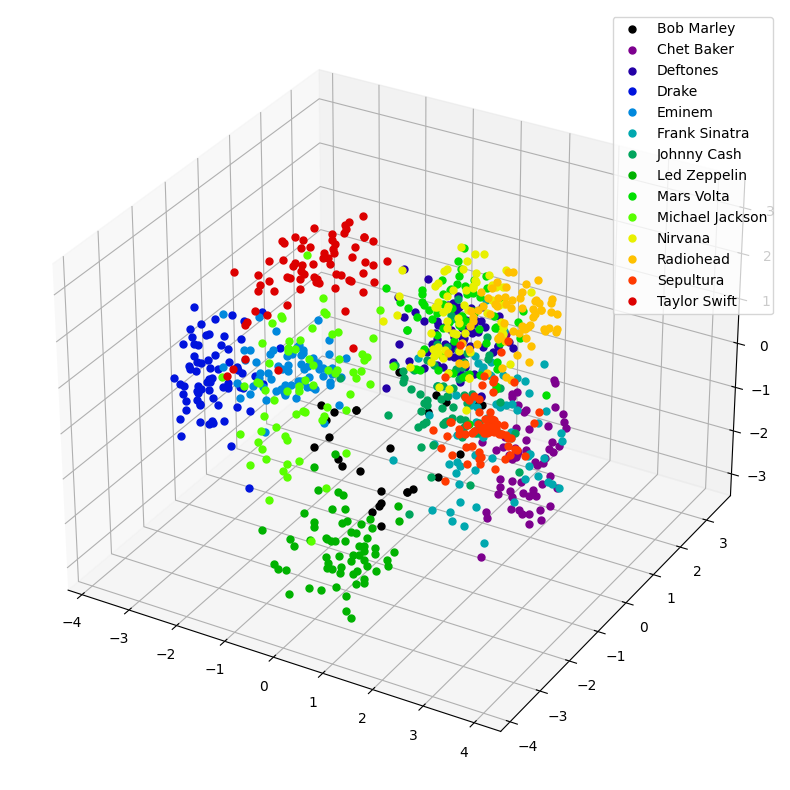

In [27]:
def pca_lowrank(A,n=2):
  U,S,V = torch.pca_lowrank(A, q=n, center=True, niter=2)
  return torch.matmul(U[:,:n],torch.diag(S[:n]))

def visualize_embeddings3D(embeddings, labels,label_mappings):
  label_set = np.unique(labels)
  num_classes = len(label_set)
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(projection='3d')

  ax.set_prop_cycle(
      cycler(
          "color", [plt.cm.nipy_spectral(i) for i in np.linspace(0,0.9, num_classes)]
      )
  )

  for i in range(num_classes):
    idx = (labels==label_set[i])
    ax.plot(embeddings[idx,0], embeddings[idx,1], embeddings[idx,2], ".", markersize=10, label=label_mappings[label_set[i]])
  plt.legend(loc="best", markerscale=1)
  plt.show()

embeddings_reduced = pca_lowrank(embeddings,3)
visualize_embeddings3D(embeddings_reduced.cpu().numpy(), labels.cpu().numpy(),artists_mappings)


### Evaluation on the test set

In [29]:
test_sampler = BaseSampler(MyDataset(test_features),batch_size=eval_batch_size)
trainer.test(best_model,train_eval_sampler,test_sampler,device)

TypeError: ignored

## Other stuff

In [ ]:
%load_ext tensorboard
%tensorboard --logdir out/prototype

In [ ]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_score,adjusted_rand_score,accuracy_score

clustering = KMeans(len(artists_mappings))
clustering.fit(embeddings.cpu().numpy())

print('ADJ:',adjusted_rand_score(clustering.predict(embeddings.cpu().numpy()),labels.cpu().numpy()))
print('Silhouette:',silhouette_score(embeddings.cpu().numpy(),clustering.predict(embeddings.cpu().numpy())))
print('Silhouette:',silhouette_score(embeddings.cpu().numpy(),labels.cpu().numpy()))
print('Accuracy:',accuracy_score(clustering.predict(embeddings.cpu().numpy()),labels.cpu().numpy()))

In [ ]:
X_train, Y_train = tuple(x.cpu().numpy() for x in get_all_embeddings(MyDataset(train_features), best_model,device))
X_test, Y_test = tuple(x.cpu().numpy() for x in get_all_embeddings(MyDataset(test_features), best_model,device))

metrics = []
ks = range(1,20)
for k in ks:
  classifier = KNeighborsClassifier(n_neighbors=k,metric='euclidean')
  classifier.fit(X_train,Y_train)
  Y_pred = classifier.predict(X_test)
  metrics.append(accuracy_score(Y_test,Y_pred))
plt.figure(figsize=(7,7))
plt.title('k - accuracy plot')
plt.plot(ks,metrics)
plt.show() 

best_knn = KNeighborsClassifier(n_neighbors=4)
best_knn.fit(X_train,Y_train)
Y_pred = best_knn.predict(X_test)
accuracy_score(Y_test,Y_pred)

## Hyperbolic space

In [22]:
trainer = Trainer(model,
                  train_sampler,
                  train_eval_sampler ,
                  val_sampler,
                  distance = 'hyperbolic' ,
                  num_epochs=num_epochs,
                  learning_rate = learning_rate,
                  max_grad_norm= max_grad_norm ,
                  es_patience=es_patience,
                  es_min_delta=es_min_delta,
                  output_dir = output_dir+"/hyperbolic",
                  device=device)
trainer.train()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0/50 - train_loss=1.069, train_acc=60.62, val_loss=2.252, val_acc=48.20


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/50 - train_loss=0.783, train_acc=72.50, val_loss=1.866, val_acc=47.88


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2/50 - train_loss=0.582, train_acc=80.31, val_loss=1.580, val_acc=51.69


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3/50 - train_loss=0.586, train_acc=77.19, val_loss=1.479, val_acc=53.21


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4/50 - train_loss=0.518, train_acc=83.12, val_loss=1.362, val_acc=59.74


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5/50 - train_loss=0.337, train_acc=87.50, val_loss=1.197, val_acc=61.15


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6/50 - train_loss=0.412, train_acc=82.50, val_loss=1.193, val_acc=62.79


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7/50 - train_loss=0.369, train_acc=85.94, val_loss=1.088, val_acc=66.81


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8/50 - train_loss=0.326, train_acc=87.19, val_loss=1.019, val_acc=67.57


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9/50 - train_loss=0.350, train_acc=87.81, val_loss=0.982, val_acc=67.03


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10/50 - train_loss=0.296, train_acc=90.62, val_loss=0.925, val_acc=69.64


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11/50 - train_loss=0.342, train_acc=86.56, val_loss=0.930, val_acc=69.86


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12/50 - train_loss=0.415, train_acc=81.88, val_loss=0.876, val_acc=72.69


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13/50 - train_loss=0.202, train_acc=92.81, val_loss=0.804, val_acc=74.32


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14/50 - train_loss=0.209, train_acc=92.50, val_loss=0.788, val_acc=76.93


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15/50 - train_loss=0.275, train_acc=89.06, val_loss=0.733, val_acc=77.26


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16/50 - train_loss=0.220, train_acc=91.25, val_loss=0.711, val_acc=76.06


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17/50 - train_loss=0.235, train_acc=90.62, val_loss=0.651, val_acc=79.33


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18/50 - train_loss=0.204, train_acc=91.56, val_loss=0.644, val_acc=77.37


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19/50 - train_loss=0.173, train_acc=94.38, val_loss=0.584, val_acc=81.07


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20/50 - train_loss=0.181, train_acc=95.00, val_loss=0.568, val_acc=81.72


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 21/50 - train_loss=0.182, train_acc=91.56, val_loss=0.563, val_acc=81.07


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 22/50 - train_loss=0.093, train_acc=97.50, val_loss=0.512, val_acc=82.37


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 23/50 - train_loss=0.134, train_acc=96.88, val_loss=0.478, val_acc=84.00


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 24/50 - train_loss=0.117, train_acc=96.25, val_loss=0.445, val_acc=86.40


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 25/50 - train_loss=0.116, train_acc=96.25, val_loss=0.475, val_acc=83.57


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 26/50 - train_loss=0.156, train_acc=92.81, val_loss=0.412, val_acc=86.72


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 27/50 - train_loss=0.081, train_acc=97.19, val_loss=0.417, val_acc=84.87


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 28/50 - train_loss=0.097, train_acc=95.94, val_loss=0.374, val_acc=86.07


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 29/50 - train_loss=0.117, train_acc=96.56, val_loss=0.370, val_acc=87.60


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 30/50 - train_loss=0.110, train_acc=96.88, val_loss=0.326, val_acc=88.79


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 31/50 - train_loss=0.053, train_acc=98.12, val_loss=0.310, val_acc=89.12


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 32/50 - train_loss=0.044, train_acc=99.06, val_loss=0.301, val_acc=89.55


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 33/50 - train_loss=0.059, train_acc=96.88, val_loss=0.273, val_acc=90.64


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 34/50 - train_loss=0.079, train_acc=97.50, val_loss=0.268, val_acc=91.29


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 35/50 - train_loss=0.085, train_acc=96.88, val_loss=0.262, val_acc=91.51


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 36/50 - train_loss=0.024, train_acc=98.75, val_loss=0.267, val_acc=91.08


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 37/50 - train_loss=0.118, train_acc=94.38, val_loss=0.233, val_acc=93.04


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 38/50 - train_loss=0.103, train_acc=95.62, val_loss=0.217, val_acc=93.47


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 39/50 - train_loss=0.042, train_acc=98.44, val_loss=0.196, val_acc=93.91


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 40/50 - train_loss=0.040, train_acc=99.06, val_loss=0.203, val_acc=93.80


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 41/50 - train_loss=0.036, train_acc=98.12, val_loss=0.206, val_acc=93.47


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 42/50 - train_loss=0.038, train_acc=99.06, val_loss=0.205, val_acc=94.23


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 43/50 - train_loss=0.043, train_acc=98.44, val_loss=0.187, val_acc=94.45


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 44/50 - train_loss=0.066, train_acc=96.88, val_loss=0.169, val_acc=95.65


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 45/50 - train_loss=0.040, train_acc=99.06, val_loss=0.158, val_acc=95.76


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 46/50 - train_loss=0.034, train_acc=98.75, val_loss=0.144, val_acc=95.65


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 47/50 - train_loss=0.046, train_acc=97.50, val_loss=0.142, val_acc=95.54


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 48/50 - train_loss=0.010, train_acc=99.69, val_loss=0.199, val_acc=93.14


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 49/50 - train_loss=0.035, train_acc=99.06, val_loss=0.154, val_acc=94.56
Finished training.


### Visualize embeddings

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/58 [00:00<?, ?it/s]

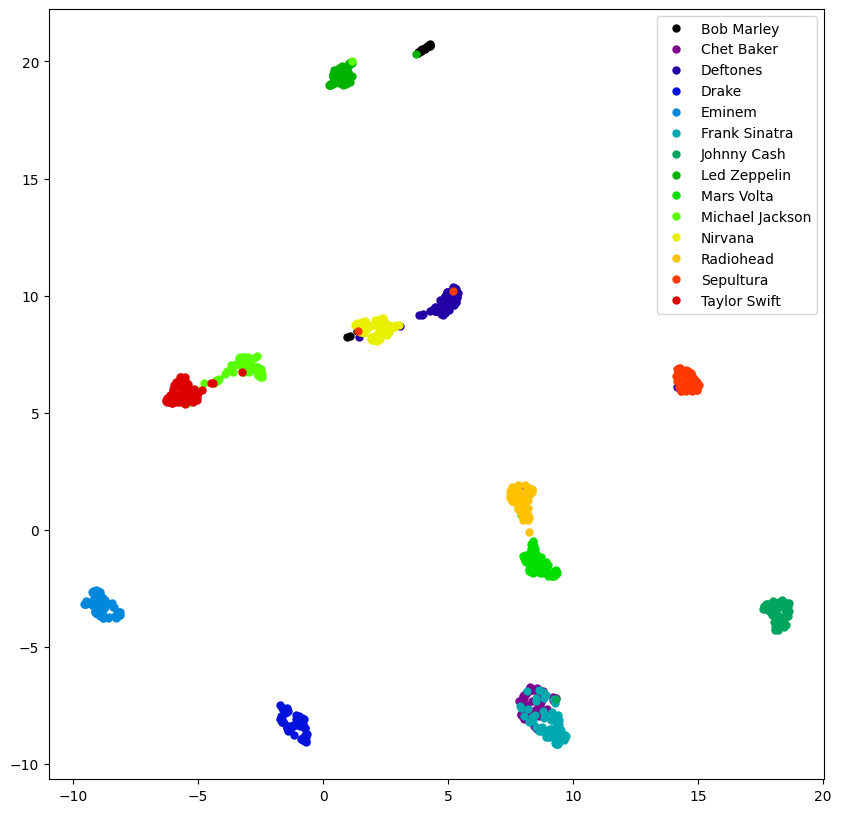

In [23]:
# Visualize the new embeddings 
best_model = PrototypicalTransformerModel(model_ckpt,128).to(device)
best_model.load_state_dict(torch.load('/content/out/prototype/hyperbolic/model.pt'))
best_model.eval()
# Visualize the new embeddings 
umap_visualizer = umap.UMAP()
embeddings, labels = get_all_embeddings(MyDataset(train_features), best_model,device)
embeddings_reduced = umap_visualizer.fit_transform(embeddings.cpu().numpy())
visualize_embeddings(embeddings_reduced, labels.cpu().numpy(),artists_mappings)

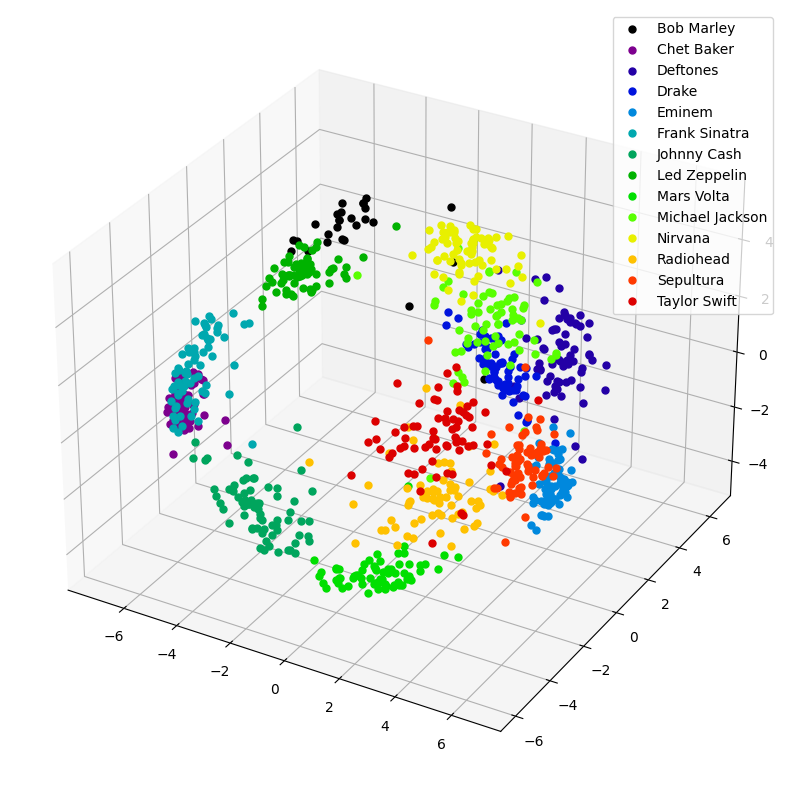

In [25]:
def pca_lowrank(A,n=2):
  U,S,V = torch.pca_lowrank(A, q=n, center=True, niter=2)
  return torch.matmul(U[:,:n],torch.diag(S[:n]))

def visualize_embeddings3D(embeddings, labels,label_mappings):
  label_set = np.unique(labels)
  num_classes = len(label_set)
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(projection='3d')

  ax.set_prop_cycle(
      cycler(
          "color", [plt.cm.nipy_spectral(i) for i in np.linspace(0,0.9, num_classes)]
      )
  )

  for i in range(num_classes):
    idx = (labels==label_set[i])
    ax.plot(embeddings[idx,0], embeddings[idx,1], embeddings[idx,2], ".", markersize=10, label=label_mappings[label_set[i]])
  plt.legend(loc="best", markerscale=1)
  plt.show()

embeddings_reduced = pca_lowrank(embeddings,3)
visualize_embeddings3D(embeddings_reduced.cpu().numpy(), labels.cpu().numpy(),artists_mappings)


## What happens when a new artists is added


In [50]:
new_dataset = load_dataset('json',data_files='data.json').class_encode_column('artist').filter(lambda x: len(x['lyrics'])>0)
new_dataset = new_dataset.map(clean)
new_artists_mappings = new_dataset['train'].features['artist'].names


def get_artists_features(dataset,artist_name):
  artist = new_dataset.filter(lambda e: e['artist']==dataset['train'].features['artist'].names.index(artist_name))
  return artist['train'].map(prepare_train_features, batched=True, remove_columns=artist["train"].column_names).with_format('torch')
  
xxx = get_artists_features(new_dataset,'XXXTENTACION')
im_dr =  get_artists_features(new_dataset,'Imagine Dragons') 
ed_sheeran = get_artists_features(new_dataset,'Ed Sheeran')

  0%|          | 0/1 [00:00<?, ?it/s]

Filter:   0%|          | 0/7185 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7185 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7185 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [51]:
umap_visualizer = umap.UMAP()
embeddings, labels = get_all_embeddings(MyDataset(train_features), best_model,device)
ed_embeddings, _ = get_all_embeddings(MyDataset(ed_sheeran), best_model,device)
xxx_embeddings, _ = get_all_embeddings(MyDataset(xxx), best_model,device)
im_dr_embeddings, _ = get_all_embeddings(MyDataset(im_dr), best_model,device)
embeddings = torch.cat((embeddings,ed_embeddings,xxx_embeddings,im_dr_embeddings),dim=0)
embeddings_reduced = umap_visualizer.fit_transform(embeddings.cpu().numpy())

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

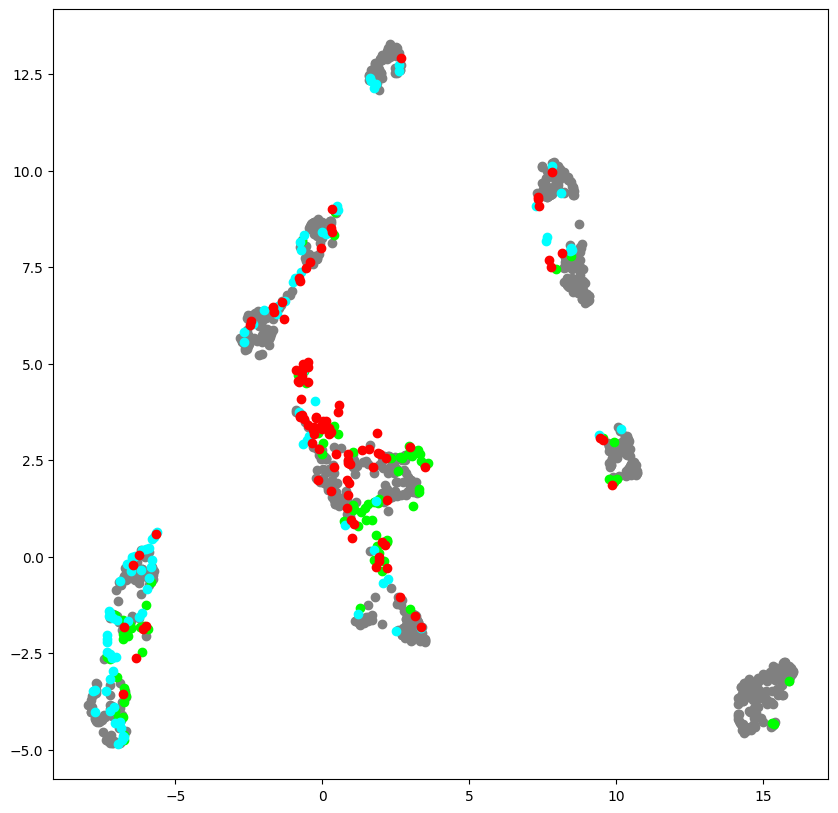

In [52]:
# Visualize the new embeddings 

plt.figure(figsize=(10,10))
plt.scatter(embeddings_reduced[:919,0],embeddings_reduced[:919,1],c = 'gray')
plt.scatter(embeddings_reduced[919:1019,0],embeddings_reduced[919:1019,1],c='lime') # Ed Sheeran
plt.scatter(embeddings_reduced[1019:1119,0],embeddings_reduced[1019:1119,1],c='cyan') # XXX
plt.scatter(embeddings_reduced[1119:,0],embeddings_reduced[1119:,1],c='red') # Imagine Dragons

plt.show()

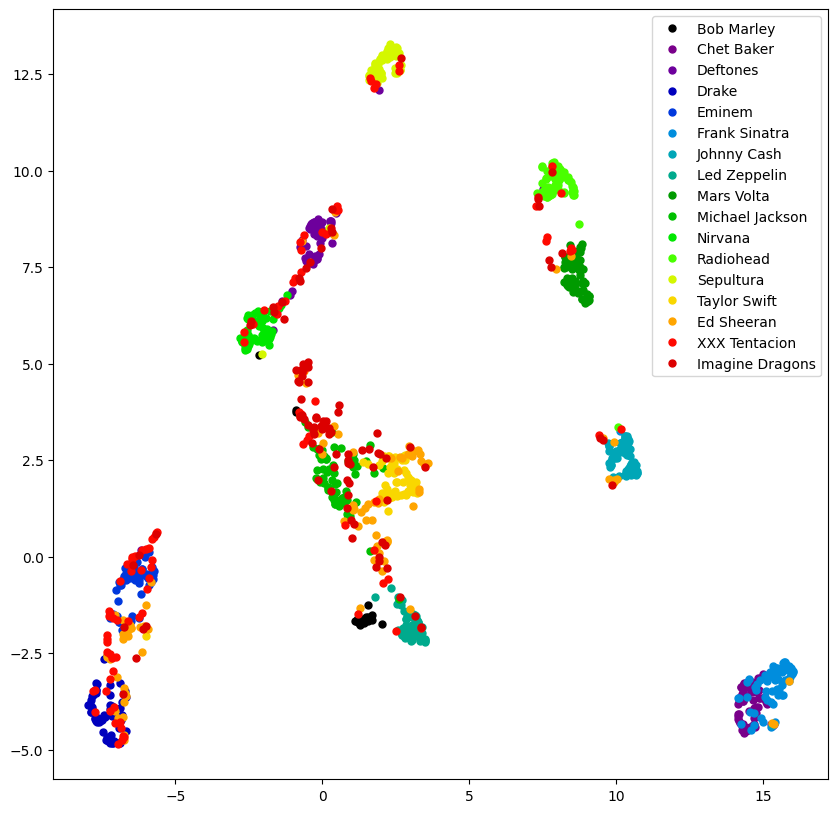

In [65]:
visualize_embeddings(embeddings_reduced[:919], labels.cpu().numpy(),artists_mappings)
plt.plot(embeddings_reduced[919:1019,0],embeddings_reduced[919:1019,1],'.',markersize=10, label = 'Ed Sheeran')
plt.plot(embeddings_reduced[1019:1119,0],embeddings_reduced[1019:1119,1],'.',markersize=10,label = 'XXX Tentacion')
plt.plot(embeddings_reduced[1119:,0],embeddings_reduced[1119:,1],'.',markersize=10,label='Imagine Dragons')
plt.legend()